In [24]:
import json
import argparse
from collections import defaultdict
import glob
from os import path
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np



In [19]:
# parser = argparse.ArgumentParser(
#     description='Adds metadata to a json file')
# parser.add_argument('file')
# args = parser.parse_args()

# file = args.file
files = glob.glob('data/*.json')
confs = defaultdict(dict)
for file in files:
    data = json.load(open(file, 'r'))
    conf_name = path.basename(file).split('.')[0]
    conf_name, year = conf_name.split('_')
    data = json.load(open(file, 'r'))
    for paper in data:
        try:
            paper['text'] = open(f"data/pdfs/{paper['id']}.txt", 'r').read().lower()
        except:
            paper['text'] = "N/A"
            pass
    confs[conf_name][year] = data




In [217]:
begin = time.time()
synonyms = {
    'facebook': ["facebook ai research", 'fb.com'],
    'google': ['google.com', 'google brain'],
    'pytorch': ['pytorch', 'allennlp', 'opennmt-py'],
    'tensorflow': ['tensorflow', 'opennmt-tf'],
    'stanford': ['@cs.stanford.edu', '@stanford.edu'],
    'mit': ['@csail.mit.edu', '@mit.edu'],
    'uw': ['@cs.washington.edu', '@washington.edu'],
    'cornell': ['@cs.cornell.edu', '@cornell.edu'],
    'cmu': ['@cmu.edu', '@cs.cmu.edu']
}
for k, v in synonyms.items():
    synonyms[k] = [i.lower() for i in v]
    
words = set([i for k,v in synonyms.items() for i in v])
mapping = defaultdict(list)
for k, vs in synonyms.items():
    for v in vs:
        mapping[v].append(k)
# print(mapping)
        
word_sets = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))
for conf in confs:
    for year in confs[conf]:
        data = confs[conf][year]
        word_set = word_sets[conf][year]
        for paper in data:
            for word in words:
                if word in paper['text']:
                    if word in mapping:
                        for key in mapping[word]:
                            word_set[key].add(paper['id'])

print(time.time() - begin)  

4.487159729003906


In [220]:
conf_month = {
    'eccv': 'september',
    'acl': 'july',
    'naacl': 'june',
    'acl': 'august',
    'icml': 'june',
    'cvpr': 'june',
    'nips': 'december',
    'aistats': 'april',
    'colt': 'june',
    'iclr': 'may',
    'iccv': 'november',
    'emnlp': 'november'
}
conf_month = {
    k: time.strptime(v, '%B').tm_mon for k, v in conf_month.items()}

eccv
acl
naacl
icml
cvpr
nips
aistats
iclr
iccv
emnlp


Text(0.5, 1.0, 'cmu')

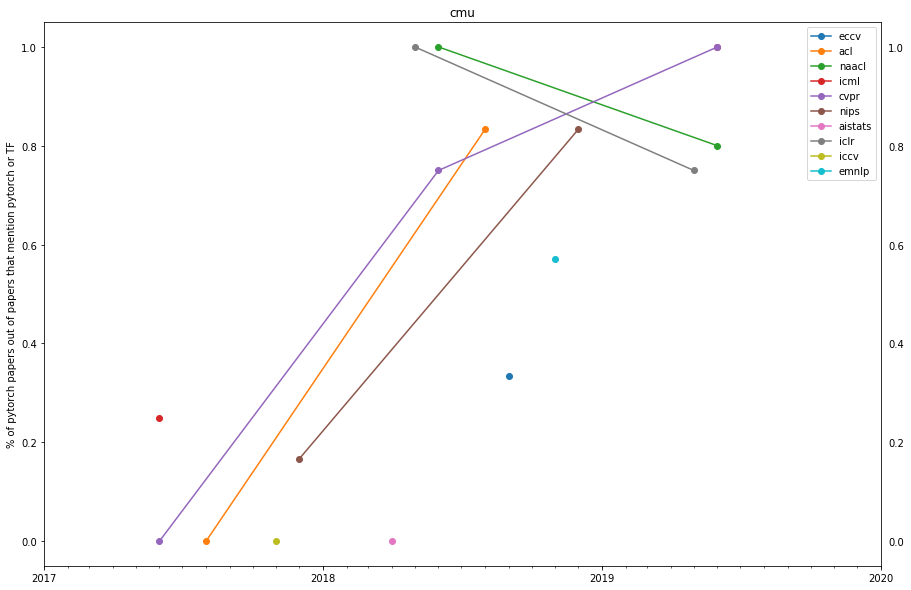

In [221]:
condition = 'cmu'
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.set_xlim(np.datetime64('2017'), np.datetime64('2020'))
ax.set_facecolor((1,1,1,1))
plt.rcParams["figure.figsize"] = (15,10)
plt.tick_params(labelright=True)
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for conf in confs:
    if conf == 'colt':
        continue
    pytorch = []
    pytorch_corr = []
    tf = []
    tf_corr = []
    dates = []
    print(conf)
    for year in sorted(confs[conf]):
        ws = word_sets[conf][year]
        date = np.datetime64(f"{year}-{conf_month[conf]:02}")
        dates.append(date)
        pytorch_set = ws['pytorch'] & ws[condition]
        tf_set = ws['tensorflow'] & ws[condition]
        biased_set = ws['facebook'] | ws['google']
        pytorch.append(len(pytorch_set))
        tf.append(len(tf_set))
        pytorch_corr.append(len(pytorch_set - biased_set))
        tf_corr.append(len(tf_set - biased_set))
#         print(tf_set)
#         print(year)
#         print("total papers", len(confs[conf][year]))
#         print("ratio: ", len(ws['pytorch'] | ws['tensorflow'])/len(confs[conf][year]))
#         print("pytorch", len(ws['pytorch']))
#         print("pytorch independent", len(ws['pytorch'] - ws['facebook']))
#         print("tensorflow", len(ws['tensorflow']))
#         print("tensorflow independent", len(ws['tensorflow'] - ws['google']))
#         print()
#     plt.figure()
    c=prop_cycle[0]
    prop_cycle = prop_cycle[1:] + prop_cycle[:1]
#     plt.plot(dates, 
#              [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch, tf)],
#             label = conf,
#             marker = 'o',
#              color = c,
#             alpha=0.3)
    plt.plot(dates, 
             [a/(a+b) if a+b > 0 else None for a,b in zip(pytorch_corr, tf_corr)],
            label = conf,
            marker = 'o',
            color=c,
            alpha=1)
    plt.legend()
    plt.ylabel('% of pytorch papers out of papers that mention pytorch or TF')
#     plt.plot(dates, pytorch, color='blue')
#     plt.plot(dates, tf, color='orange')
plt.title(condition)

In [123]:
conf = 'iclr'

for year in sorted(confs[conf]):
    ws = word_sets[conf][year]

    print(year)
    print("total papers", len(confs[conf][year]))
    print("pytorch", len(ws['pytorch'] & ws['rl']))
    print("pytorch independent", len(ws['pytorch'] - ws['facebook']))
    print("tensorflow", len(ws['tensorflow'] & ws['rl']))
    print("tensorflow independent", len(ws['tensorflow'] - ws['google']))
    print()


2015
total papers 602
pytorch 0
pytorch independent 0
tensorflow 0
tensorflow independent 0

2016
total papers 643
pytorch 0
pytorch independent 0
tensorflow 1
tensorflow independent 1

2017
total papers 783
pytorch 0
pytorch independent 0
tensorflow 7
tensorflow independent 44

2018
total papers 979
pytorch 18
pytorch independent 88
tensorflow 22
tensorflow independent 123

2019
total papers 1294
pytorch 53
pytorch independent 309
tensorflow 28
tensorflow independent 151

